In [1]:
#import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

In [2]:
def bar_plot(mix_data, est_data, mvng_est_data, x_axis_lst, ylabel, title):
        barWidth = 0.25
        

        br1 = np.arange(len(mix_data))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        plt.figure()
        plt.bar(br1, mix_data, color ='b', width = barWidth,
                edgecolor ='grey', label ='mix')
        plt.bar(br2, est_data, color ='g', width = barWidth,
                edgecolor ='grey', label ='est')
        plt.bar(br3, mvng_est_data, color ='r', width = barWidth,
                edgecolor ='grey', label ='moving_est')

        plt.xticks( [r + barWidth for r in range(len(mix_data))],
                x_axis_lst)
        plt.xlabel('t60')
        plt.ylabel(ylabel)
        plt.legend()
        plt.title(title)

        data_lim = [mix_data, est_data, mvng_est_data]
        min_val = round(np.min(data_lim), 2)
        max_val = round(np.max(data_lim), 2)
        #plt.yticks(np.arange(min_val-0.02, max_val+0.02, step=0.02))
        #plt.ylim([min_val-0.02, max_val+ 0.02])
        #print(min_val, max_val)
        metric = ylabel
        if "snr" in metric:
                plt.ylim([min_val-1, max_val+1])
        elif "pesq" in metric:
                plt.yticks(np.arange(min_val-0.5, max_val+0.5, step=0.1))
                plt.ylim([min_val-0.2, max_val+0.2])
        elif "stoi" in metric:
                
                plt.yticks(np.arange(min_val-0.5, max_val+0.5, step=1))
                plt.ylim([min_val-0.1, max_val+ 0.1])
        elif "frm_Acc" in metric or "blk_Acc" in metric:
                plt.yticks(np.arange(min_val-0.5, max_val+0.5, step=5))
                plt.ylim([min_val-0.1, max_val+ 0.1])

In [3]:
def plot_metrics(info):
    "Expects a dictionary with keys"
    metrics_list = list(info['mvng_est_metrics'].keys())

    for metric in metrics_list:
        data = [info['mix_metrics'][metric], info['est_metrics'][metric], info['mvng_est_metrics'][metric]]
        plt.figure()
        plt.bar(["mix", "est", "mvng_est"], data)
        plt.ylabel(metric)
        if "snr" in metric:
            plt.ylim([min(data)-1, max(data)+1])
        elif "pesq" in metric:
            plt.yticks(np.arange(min(data)-0.5, max(data)+0.5, step=0.1))
            plt.ylim([min(data)-0.5, max(data)+0.5])
            
        elif "stoi" in metric:
            plt.yticks(np.arange(min(data)-0.5, max(data)+0.5, step=0.01))
            plt.ylim([min(data)-0.1, max(data)+ 0.1])

In [4]:
scenarios = ["stationary", "moving"]
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0] # rows 
snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0] # col

metrics = namedtuple('metrics', ["mix_stoi", "enh_stoi", "mix_pesq_nb", "enh_pesq_nb"])
doa_metrics = namedtuple('doa_metrics', ["mix_frm_Acc", "est_frm_Acc", "mix_blk_Acc", "est_blk_Acc"])

In [5]:
import torch
dataset_condition = "reverb"
exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_results.pt')

FileNotFoundError: [Errno 2] No such file or directory: '../Logs/reverb/reverb_results.pt'

In [ ]:
def get_metrics(mic_idx, train, t60_list, snr, metric, dataset_condition, comparison_domain):
    #Getting list of each case
    mix_metrics = []
    enh_metrics = []
    mvng_enh_metrics = []
    mvng_mix_metrics = []


    for t60 in t60_list:
        for test in scenarios:

            if dataset_condition =="reverb":
                exp_app_str = f't60_{t60}'
            elif dataset_condition =="noisy":
                exp_app_str = f'snr_{snr}'
            elif dataset_condition =="noisy_reverb":
                exp_app_str = f't60_{t60}_snr_{snr}'
            else:
                exp_app_str = ''

            key_str = f'train_{train}_mic_idx_{mic_idx}_test_{test}_{exp_app_str}' if comparison_domain!="doa" else f'train_{train}_test_{test}_{exp_app_str}'
            
            metrics = exp_dict[key_str]._asdict()
            start_phrase = "est" if comparison_domain =="doa" else "enh"
            
            if test=="stationary":
                mix_metrics.append(metrics[f'mix_{metric}'])
                enh_metrics.append(metrics[f'{start_phrase}_{metric}'])
            elif test=="moving":
                mvng_mix_metrics.append(metrics[f'mix_{metric}'])
                mvng_enh_metrics.append(metrics[f'{start_phrase}_{metric}'])
            else:
                break

            #print(f'{t60}, {test}, {exp_dict[key_str]}')

    if metric =="stoi" or metric == "frm_Acc" or metric == "blk_Acc":
        stoi_format= lambda lst: [ round(float(x)*100, 2) for x in lst]

        mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics = stoi_format(mix_metrics), stoi_format(enh_metrics), stoi_format(mvng_enh_metrics), stoi_format(mvng_mix_metrics)

    else:
        pesq_format= lambda lst: [ round(float(x), 2) for x in lst]

        mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics = pesq_format(mix_metrics), pesq_format(enh_metrics), pesq_format(mvng_enh_metrics), pesq_format(mvng_mix_metrics)


    return mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics

In [ ]:
def get_noisy_metrics(mic_idx, train, snr_list, t60, metric, dataset_condition, comparison_domain):
    #Getting list of each case
    mix_metrics = []
    enh_metrics = []
    mvng_enh_metrics = []
    mvng_mix_metrics = []


    for snr in snr_list:
        for test in scenarios:

            if dataset_condition =="reverb":
                exp_app_str = f't60_{t60}'
            elif dataset_condition =="noisy":
                exp_app_str = f'snr_{snr}'
            elif dataset_condition =="noisy_reverb":
                exp_app_str = f't60_{t60}_snr_{snr}'
            else:
                exp_app_str = ''

            key_str = f'train_{train}_mic_idx_{mic_idx}_test_{test}_{exp_app_str}' if comparison_domain!="doa" else f'train_{train}_test_{test}_{exp_app_str}'
            
            metrics = exp_dict[key_str]._asdict()
            start_phrase = "est" if comparison_domain =="doa" else "enh"
            if test=="stationary":
                mix_metrics.append(metrics[f'mix_{metric}'])
                enh_metrics.append(metrics[f'{start_phrase}_{metric}'])
            elif test=="moving":
                mvng_mix_metrics.append(metrics[f'mix_{metric}'])
                mvng_enh_metrics.append(metrics[f'{start_phrase}_{metric}'])
            else:
                break

            #print(f'{t60}, {test}, {exp_dict[key_str]}')

    if metric =="stoi" or metric == "frm_Acc" or metric == "blk_Acc":
        stoi_format= lambda lst: [ round(float(x)*100, 2) for x in lst]

        mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics = stoi_format(mix_metrics), stoi_format(enh_metrics), stoi_format(mvng_enh_metrics), stoi_format(mvng_mix_metrics)

    else:
        pesq_format= lambda lst: [ round(float(x), 2) for x in lst]

        mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics = pesq_format(mix_metrics), pesq_format(enh_metrics), pesq_format(mvng_enh_metrics), pesq_format(mvng_mix_metrics)


    return mix_metrics, enh_metrics, mvng_metrics, mvng_mix_metrics

In [ ]:
#mic_idx=1
#train = 'moving'
#snr = -5.0
#metric = 'stoi'
#mix_stoi, enh_stoi, mvng_stoi, mvng_mix_stoi = get_metrics(mic_idx, train, snr, metric)
#mix_pesq, enh_pesq, mvng_pesq, mvng_mix_pesq = get_metrics(mic_idx, train, snr, metric="pesq_nb")


In [ ]:
#bar_plot(mix_stoi, enh_stoi, mvng_stoi, ylabel='stoi', title=train )
#bar_plot(mix_pesq, enh_pesq, mvng_pesq, ylabel='pesq', title=train )

In [ ]:
def perf_gap(stat_list, mvng_list):
    return [abs(i-j) for i,j in zip(stat_list, mvng_list)]


In [ ]:
def perf_gap_automation(stat_list, mvng_list):
    _gap=[i-j for i,j in zip(stat_list, mvng_list)]
    plt.stem(t60_list, _gap)

In [ ]:
#stoi_gap = perf_gap(enh_stoi, mvng_stoi)
#print(stoi_gap)
#plt.stem(t60_list, stoi_gap)

In [ ]:
#pesq_gap = perf_gap(enh_pesq, mvng_pesq)
#print(pesq_gap)
#plt.stem(t60_list, pesq_gap)

In [ ]:
#mix_gap = perf_gap(mix_pesq, mvng_mix_pesq)
#print(mix_gap)
#plt.stem(t60_list, mix_gap)

#mix_stoi_gap = perf_gap(mix_stoi, mvng_mix_stoi)
#print(mix_stoi_gap)
#plt.figure()
#plt.stem(t60_list, mix_stoi_gap)

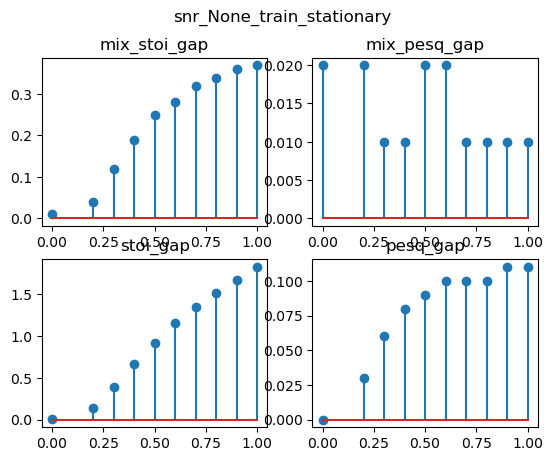

In [ ]:
#Automation

dataset_condition="reverb"
comparison_domain = ""
mic_idx=1
train = 'stationary'
snr_list =  [None]
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#metric = 'stoi'
for snr in snr_list:
    mix_stoi, enh_stoi, mvng_stoi, mvng_mix_stoi = get_metrics(mic_idx, train, t60_list, snr, metric="stoi", dataset_condition=dataset_condition, comparison_domain=comparison_domain)
    mix_pesq, enh_pesq, mvng_pesq, mvng_mix_pesq = get_metrics(mic_idx, train, t60_list, snr, metric="pesq_nb", dataset_condition=dataset_condition, comparison_domain=comparison_domain)

    mix_stoi_gap = perf_gap(mix_stoi, mvng_mix_stoi)
    mix_pesq_gap = perf_gap(mix_pesq, mvng_mix_pesq)

    plt.figure()
    plt.suptitle(f'snr_{snr}_train_{train}')

    plt.subplot(2,2,1)
    plt.stem(t60_list, mix_stoi_gap)
    plt.title('mix_stoi_gap')
    
    plt.subplot(2,2,2)
    plt.stem(t60_list, mix_pesq_gap)
    plt.title(f'mix_pesq_gap')

    stoi_gap = perf_gap(enh_stoi, mvng_stoi)
    pesq_gap = perf_gap(enh_pesq, mvng_pesq)

    plt.subplot(2,2,3)
    plt.stem(t60_list, stoi_gap)
    plt.title('stoi_gap')
    

    plt.subplot(2,2,4)
    plt.stem(t60_list, pesq_gap)
    plt.title(f'pesq_gap')



    

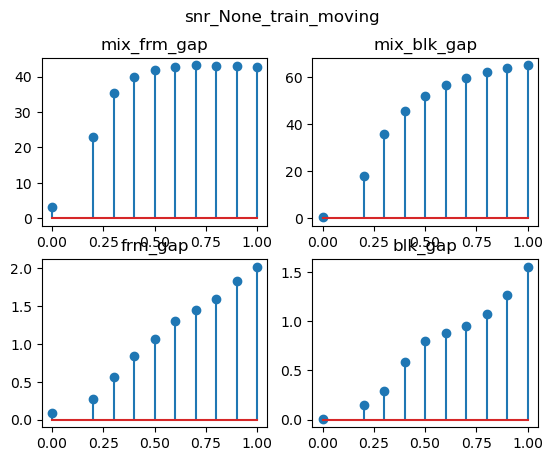

In [ ]:

import torch
dataset_condition = "reverb"
comparison_domain = "doa"
exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_{comparison_domain}_results.pt')

train = 'moving'
snr_list =  [None]
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#metric = 'stoi'
for snr in snr_list:
    mix_frm_Acc, enh_frm_Acc, mvng_frm_Acc, mvng_mix_frm_Acc = get_metrics(mic_idx, train, t60_list, snr, metric="frm_Acc", dataset_condition=dataset_condition, comparison_domain=comparison_domain)
    mix_blk_Acc, enh_blk_Acc, mvng_blk_Acc, mvng_mix_blk_Acc = get_metrics(mic_idx, train, t60_list, snr, metric="blk_Acc", dataset_condition=dataset_condition, comparison_domain=comparison_domain)

    mix_frm_gap = perf_gap(mix_frm_Acc, mvng_frm_Acc)
    mix_blk_gap = perf_gap(mix_blk_Acc, mvng_blk_Acc)

    plt.figure()
    plt.suptitle(f'snr_{snr}_train_{train}')

    plt.subplot(2,2,1)
    plt.stem(t60_list, mix_frm_gap)
    plt.title('mix_frm_gap')
    
    plt.subplot(2,2,2)
    plt.stem(t60_list, mix_blk_gap)
    plt.title(f'mix_blk_gap')

    frm_gap = perf_gap(enh_frm_Acc, mvng_frm_Acc)
    blk_gap = perf_gap(enh_blk_Acc, mvng_blk_Acc)

    plt.subplot(2,2,3)
    plt.stem(t60_list, frm_gap)
    plt.title('frm_gap')
    

    plt.subplot(2,2,4)
    plt.stem(t60_list, blk_gap)
    plt.title(f'blk_gap')

21.09 99.95
25.29 100.0


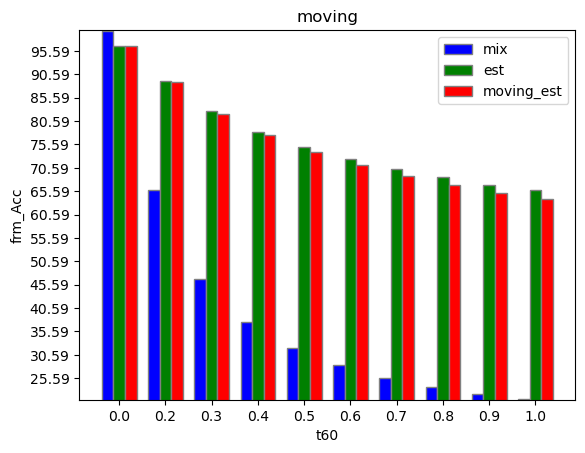

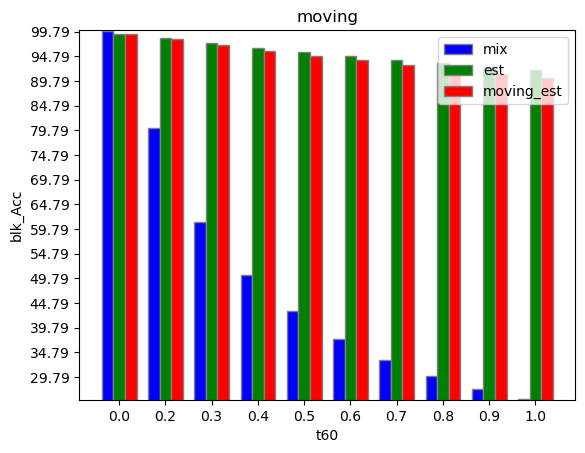

In [ ]:
t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
str_t60_list = [str(x) for x in t60_list]
bar_plot(mix_frm_Acc, enh_frm_Acc, mvng_frm_Acc, x_axis_lst = str_t60_list, ylabel='frm_Acc', title=train )
bar_plot(mix_blk_Acc, enh_blk_Acc, mvng_blk_Acc, x_axis_lst = str_t60_list, ylabel='blk_Acc', title=train )

Text(0.5, 1.0, 'pesq_gap')

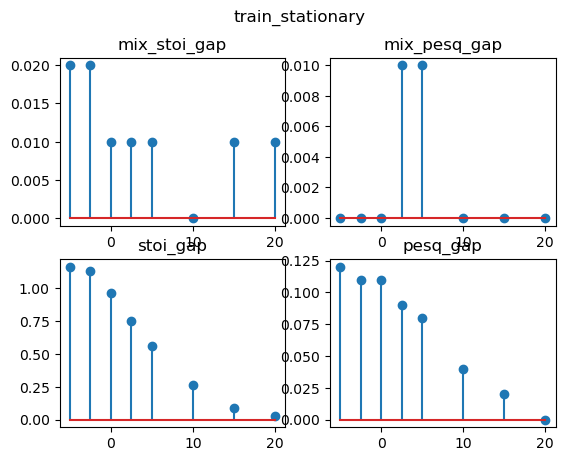

In [ ]:
#Automation

import torch


dataset_condition="noisy"
comparison_domain = ""
exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_{comparison_domain}results.pt')

mic_idx=0
train = 'stationary'
snr_list =  [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
t60 = None
#snr_list =  [None]
#t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#metric = 'stoi'

mix_stoi, enh_stoi, mvng_stoi, mvng_mix_stoi = get_noisy_metrics(mic_idx, train, snr_list, t60, metric="stoi", dataset_condition=dataset_condition, comparison_domain=comparison_domain)
mix_pesq, enh_pesq, mvng_pesq, mvng_mix_pesq = get_noisy_metrics(mic_idx, train, snr_list, t60, metric="pesq_nb", dataset_condition=dataset_condition, comparison_domain=comparison_domain)

mix_stoi_gap = perf_gap(mix_stoi, mvng_mix_stoi)
mix_pesq_gap = perf_gap(mix_pesq, mvng_mix_pesq)

plt.figure()
plt.suptitle(f'train_{train}')

plt.subplot(2,2,1)
plt.stem(snr_list, mix_stoi_gap)
plt.title('mix_stoi_gap')

plt.subplot(2,2,2)
plt.stem(snr_list, mix_pesq_gap)
plt.title(f'mix_pesq_gap')

stoi_gap = perf_gap(enh_stoi, mvng_stoi)
pesq_gap = perf_gap(enh_pesq, mvng_pesq)

plt.subplot(2,2,3)
plt.stem(snr_list, stoi_gap)
plt.title('stoi_gap')


plt.subplot(2,2,4)
plt.stem(snr_list, pesq_gap)
plt.title(f'pesq_gap')



    

Text(0.5, 1.0, 'blk_gap')

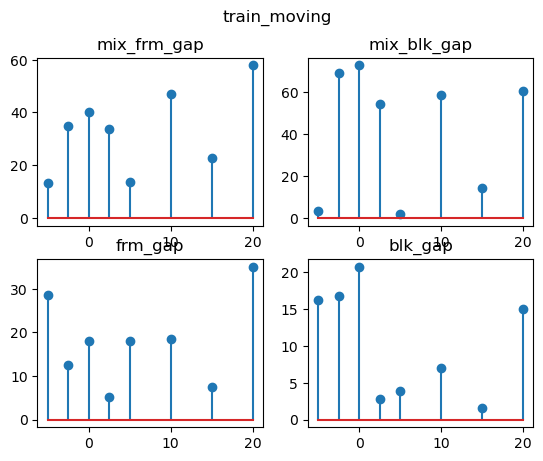

In [ ]:

import torch
dataset_condition = "noisy"
comparison_domain = "doa"
exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_{comparison_domain}_results.pt')

train = 'moving'
snr_list =  [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
t60 = None
#t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#metric = 'stoi'
mic_idx = 0

mix_frm_Acc, enh_frm_Acc, mvng_frm_Acc, mvng_mix_frm_Acc = get_noisy_metrics(mic_idx, train, snr_list, t60, metric="frm_Acc", dataset_condition=dataset_condition, comparison_domain=comparison_domain)
mix_blk_Acc, enh_blk_Acc, mvng_blk_Acc, mvng_mix_blk_Acc = get_noisy_metrics(mic_idx, train, snr_list, t60, metric="blk_Acc", dataset_condition=dataset_condition, comparison_domain=comparison_domain)

mix_frm_gap = perf_gap(mix_frm_Acc, mvng_frm_Acc)
mix_blk_gap = perf_gap(mix_blk_Acc, mvng_blk_Acc)

plt.figure()
plt.suptitle(f'train_{train}')

plt.subplot(2,2,1)
plt.stem(snr_list, mix_frm_gap)
plt.title('mix_frm_gap')

plt.subplot(2,2,2)
plt.stem(snr_list, mix_blk_gap)
plt.title(f'mix_blk_gap')

frm_gap = perf_gap(enh_frm_Acc, mvng_frm_Acc)
blk_gap = perf_gap(enh_blk_Acc, mvng_blk_Acc)

plt.subplot(2,2,3)
plt.stem(snr_list, frm_gap)
plt.title('frm_gap')


plt.subplot(2,2,4)
plt.stem(snr_list, blk_gap)
plt.title(f'blk_gap')

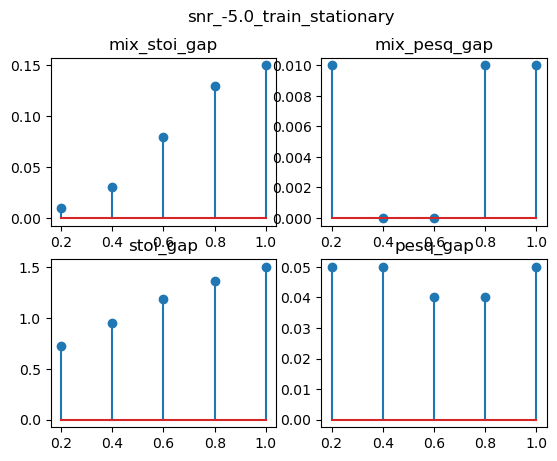

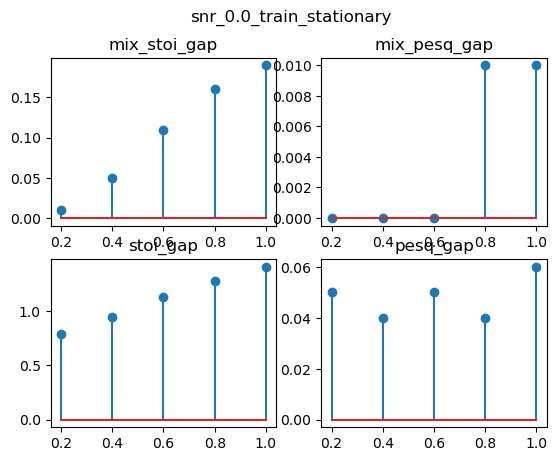

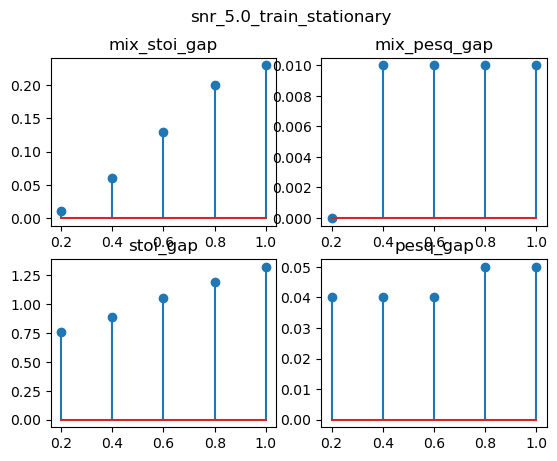

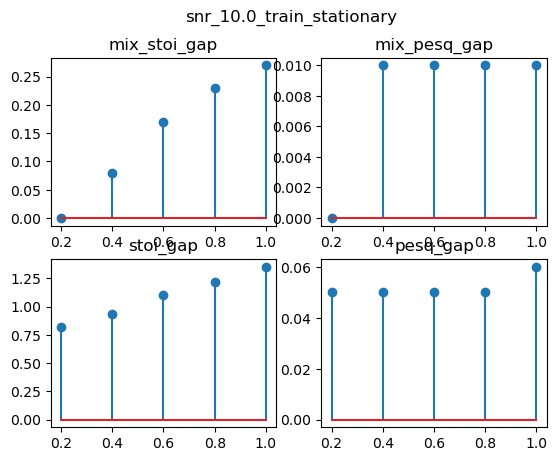

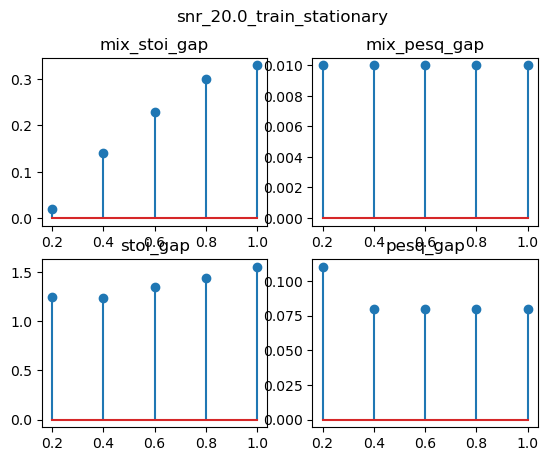

In [ ]:
#Automation

dataset_condition="noisy_reverb"
comparison_domain = ""
exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_{comparison_domain}results.pt')

mic_idx=1
train = 'stationary'
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0] # rows 
snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0] # col
#metric = 'stoi'
for snr in snr_list:
    mix_stoi, enh_stoi, mvng_stoi, mvng_mix_stoi = get_metrics(mic_idx, train, t60_list, snr, metric="stoi", dataset_condition=dataset_condition, comparison_domain=comparison_domain)
    mix_pesq, enh_pesq, mvng_pesq, mvng_mix_pesq = get_metrics(mic_idx, train, t60_list, snr, metric="pesq_nb", dataset_condition=dataset_condition, comparison_domain=comparison_domain)

    mix_stoi_gap = perf_gap(mix_stoi, mvng_mix_stoi)
    mix_pesq_gap = perf_gap(mix_pesq, mvng_mix_pesq)

    plt.figure()
    plt.suptitle(f'snr_{snr}_train_{train}')

    plt.subplot(2,2,1)
    plt.stem(t60_list, mix_stoi_gap)
    plt.title('mix_stoi_gap')
    
    plt.subplot(2,2,2)
    plt.stem(t60_list, mix_pesq_gap)
    plt.title(f'mix_pesq_gap')

    stoi_gap = perf_gap(enh_stoi, mvng_stoi)
    pesq_gap = perf_gap(enh_pesq, mvng_pesq)

    plt.subplot(2,2,3)
    plt.stem(t60_list, stoi_gap)
    plt.title('stoi_gap')
    

    plt.subplot(2,2,4)
    plt.stem(t60_list, pesq_gap)
    plt.title(f'pesq_gap')



    

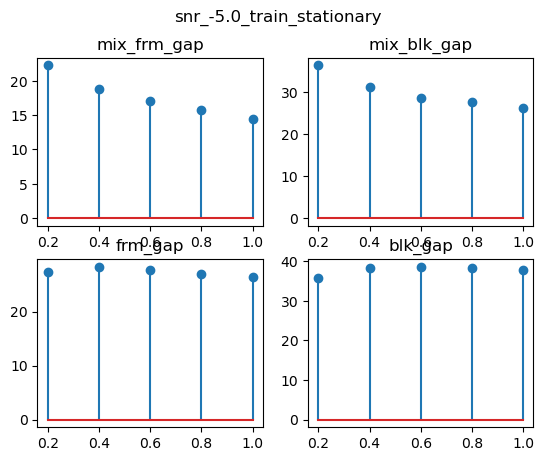

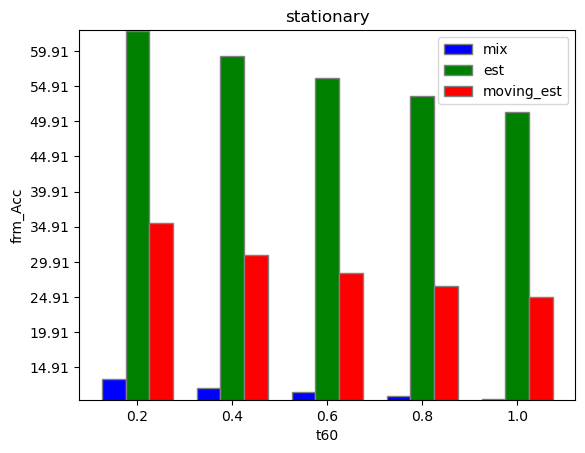

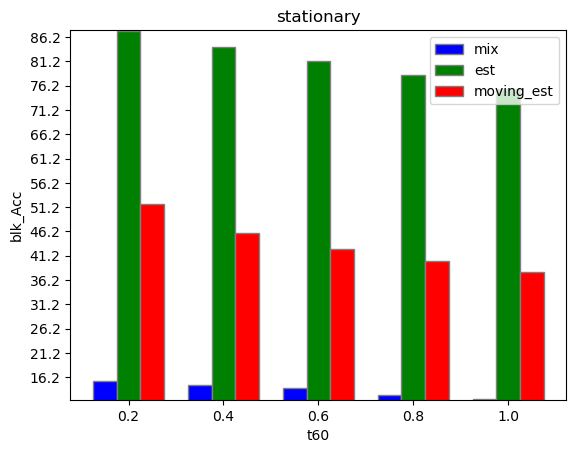

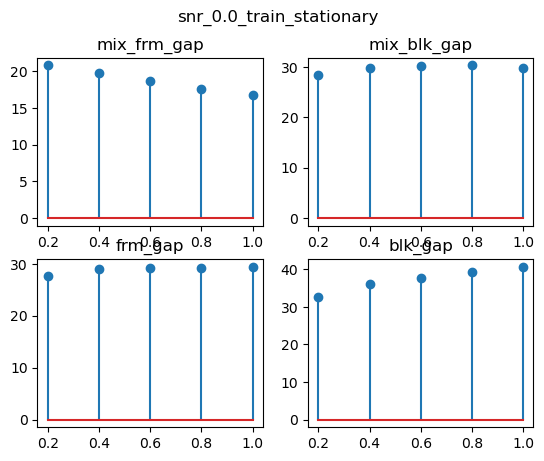

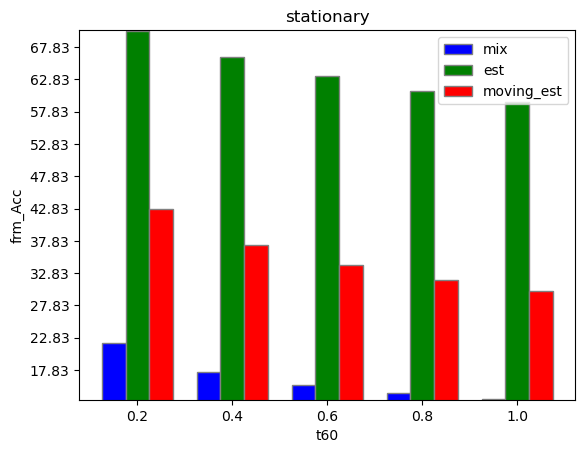

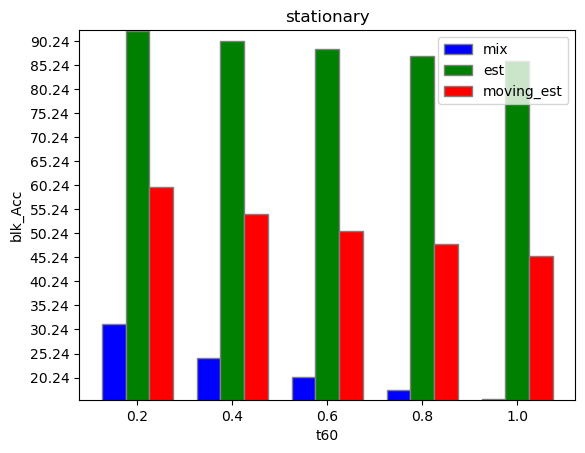

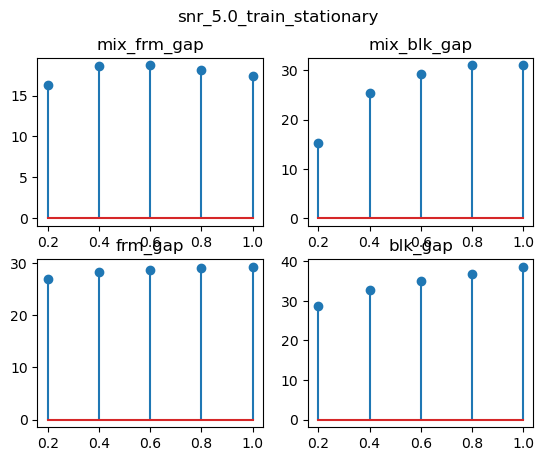

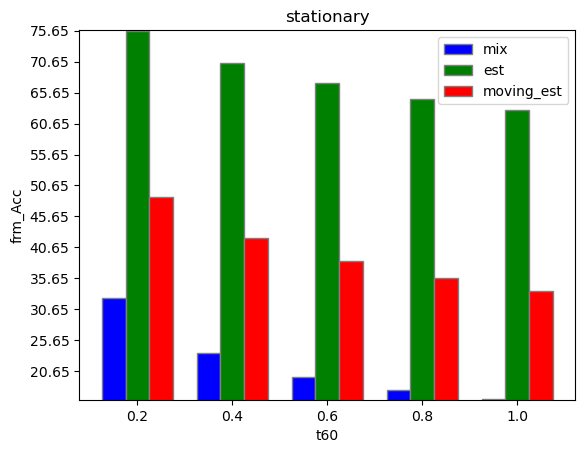

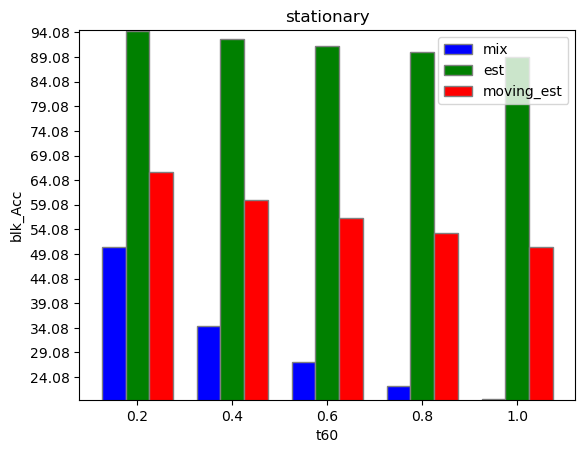

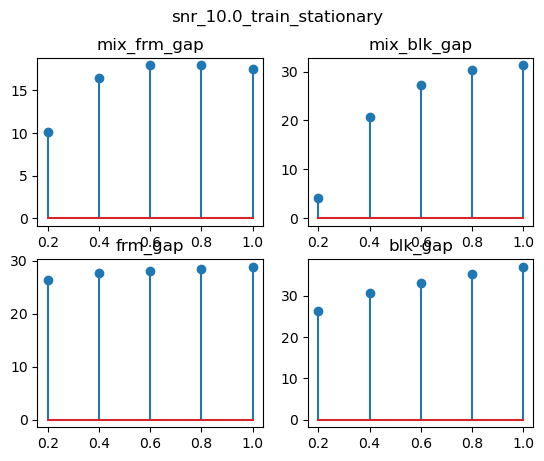

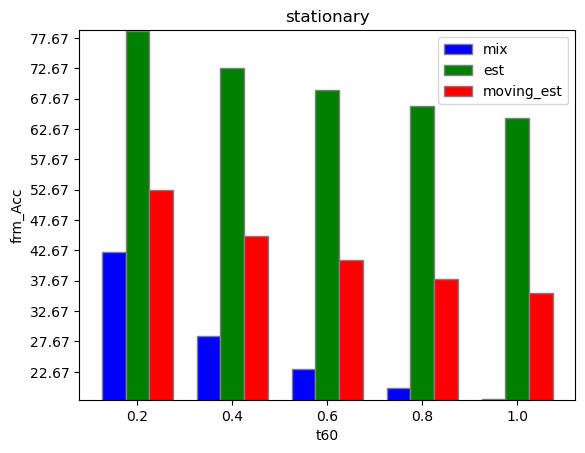

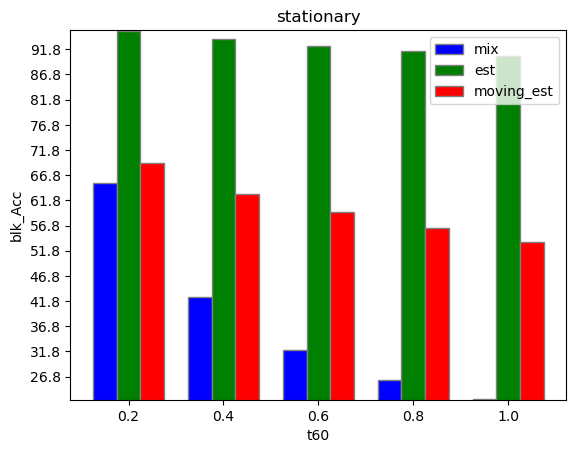

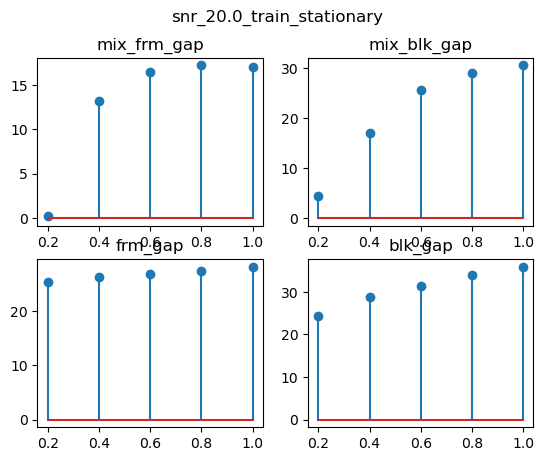

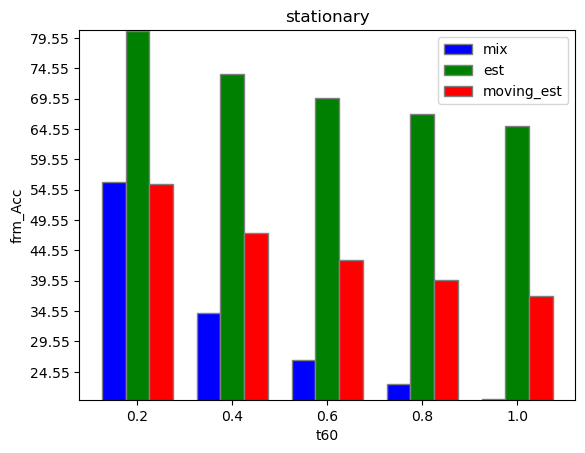

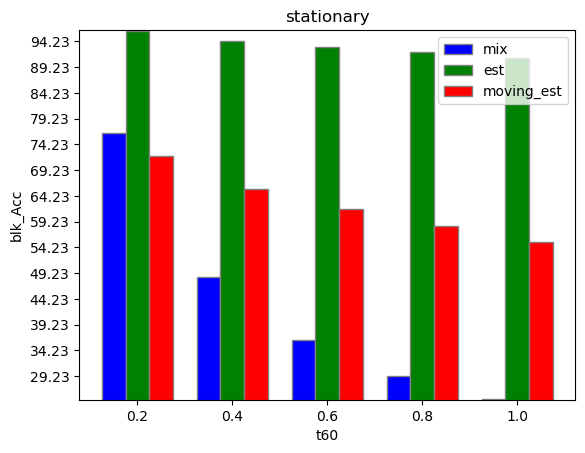

In [ ]:

import torch
dataset_condition = "noisy_reverb"
comparison_domain = "doa"
exp_dict = torch.load(f'../Logs/{dataset_condition}/{dataset_condition}_{comparison_domain}_results.pt')

train = 'moving'
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0] # rows 
snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0] # col
str_t60_list = [str(x) for x in t60_list]
#metric = 'stoi'
for snr in snr_list:
    mix_frm_Acc, enh_frm_Acc, mvng_frm_Acc, mvng_mix_frm_Acc = get_metrics(mic_idx, train, t60_list, snr, metric="frm_Acc", dataset_condition=dataset_condition, comparison_domain=comparison_domain)
    mix_blk_Acc, enh_blk_Acc, mvng_blk_Acc, mvng_mix_blk_Acc = get_metrics(mic_idx, train, t60_list, snr, metric="blk_Acc", dataset_condition=dataset_condition, comparison_domain=comparison_domain)

    mix_frm_gap = perf_gap(mix_frm_Acc, mvng_frm_Acc)
    mix_blk_gap = perf_gap(mix_blk_Acc, mvng_blk_Acc)

    plt.figure()
    plt.suptitle(f'snr_{snr}_train_{train}')

    plt.subplot(2,2,1)
    plt.stem(t60_list, mix_frm_gap)
    plt.title('mix_frm_gap')
    
    plt.subplot(2,2,2)
    plt.stem(t60_list, mix_blk_gap)
    plt.title(f'mix_blk_gap')

    frm_gap = perf_gap(enh_frm_Acc, mvng_frm_Acc)
    blk_gap = perf_gap(enh_blk_Acc, mvng_blk_Acc)

    plt.subplot(2,2,3)
    plt.stem(t60_list, frm_gap)
    plt.title('frm_gap')
    

    plt.subplot(2,2,4)
    plt.stem(t60_list, blk_gap)
    plt.title(f'blk_gap')

    
    bar_plot(mix_frm_Acc, enh_frm_Acc, mvng_frm_Acc, x_axis_lst = str_t60_list, ylabel='frm_Acc', title=train )
    bar_plot(mix_blk_Acc, enh_blk_Acc, mvng_blk_Acc, x_axis_lst = str_t60_list, ylabel='blk_Acc', title=train )

In [ ]:
snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0] # col
t60_list = [0.2, 0.4, 0.6, 0.8, 1.0] # rows 


# Results : Automation 

Tr | Test

S  |   S    M    -----> Performace gap \
M  |   S    M    -----> Similarity

NameError: name 'torch' is not defined